<h1><center>Navigation<center></h1>
<h2><center>Implementing Deep Q-Learning to solve a Banana Collector environment<center></h2>

<div style="text-align: right"><i>Note: The project environment is similar to,<i></div>
<div style="text-align: right"><i>but not identical to the Banana Collector environment<i></div>
<div style="text-align: right"><i>on the Unity ML-Agents GitHub page.<i></div>
    
---


This notebook was run in the Udacity coding environment to train my agent for the project. 

* The present **Jupyter Notebook** includes functional, well-documented code, and organized code for training the agent.
* The **Readme** file of this repository describes the project environment, provides instructions for installing dependencies or downloading needed files, and how to run the code to train the agent.
* The **Report** provides a description of the implementation of this project, including a plot of rewards and ideas for future improvements.

### 1. Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Setting up my own agent

In [5]:
# necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
import tqdm




In [6]:
# QNetwork

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Builds a model
        Args:
          state_size (int): dimension of each state
          action_size (int): dimension of each action
          fc1_units (int): the number of nodes in first hidden layer
          fc2_units (int): the number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Builds a network that maps state -> action values"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# replay Buffer

"""Replay Buffer"""

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, device=torch.device('cpu')):
        """ReplayBuffer object
        Params
        ======
          action_size (int): dimension of each action
          buffer_size (int): maximum size of buffer
          batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.device = device
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
# agent

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network



class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, fc1_units=fc1_units, fc2_units=fc2_units).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, fc1_units=fc1_units, fc2_units=fc2_units).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # initialize qnetwork_target parameters to qnetwork_local
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1)

        # replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, device=self.device)
        # initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        # set qnetwork_local to evaluation mode
        self.qnetwork_local.eval()

        # this operation should not be included in gradient calculation
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        
        # set qnetwork_local to training mode
        self.qnetwork_local.train()

        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # minimize the loss
        # clear the gradients of all optimized variables
        self.optimizer.zero_grad()
        
        # backward pass
        loss.backward()
        
        # perform a single optimization step
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### 4.Train

In [7]:
"""Trains the agent using Deep Q-Learning"""

def dqn(env, agent, n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, show_progress=True):
    """Deep Q-Learning
    Params
    ======
      n_episodes (int): maximum number of training episodes
      max_t (int): maximum number of timesteps per episodes
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    # get the default brain
    brain_name = env.brain_names[0]
    # list containing scores from each episode
    scores = []                         
    # last 100 scores
    scores_window = deque(maxlen=100)   
    # initialize epsilon
    eps = eps_start                     
    progress = tqdm.tqdm(range(1, n_episodes + 1), disable=not show_progress)
    for i_episode in progress:
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # get the current state
        state = env_info.vector_observations[0]
        # initialize the score
        score = 0

        for _ in range(max_t):
            # do an action
            action = agent.act(state)
            # send action to the environment
            env_info = env.step(action)[brain_name]
            # get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            # see if episode has finished
            done = env_info.local_done[0]
            # step
            agent.step(state, action, reward, next_state, done)
            # roll over state to next time step
            state = next_state
            # update score
            score += reward
            # exit loop if episode finished
            if done:
                break

        # save most recent score
        scores_window.append(score)        
        # save most recent score
        scores.append(score)               
        scores_mean = np.mean(scores_window)
        #print(f'\rEpisode {i_episode}\tAverage Score: {scores_mean:.2f}', end='')
        progress.set_postfix({'episode': i_episode, 'score_mean': scores_mean})

        if scores_mean >= 13.:
            print(f'\nEnvironment solved in {i_episode - 100} episodes!')
            print(f'Average Score: {scores_mean}')
            torch.save(agent.qnetwork_local.state_dict(), 'qnetwork_local_checkpoint.pth')
            break

        eps = max(eps_end, eps_decay * eps)

    return scores


def train(env, n_episodes=1500, max_t=1000, agent_kwargs={}, seed=None,
          save_filename='project1_dqn_agent.pth', show_progress=True, **kwargs):
    """Trains the agent
    """
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    env_info = env.reset(train_mode=True)[brain_name]

    # the number of actions
    action_size = brain.vector_action_space_size

    # the dimension of state vector
    state_size = len(env_info.vector_observations[0])

    # create an agent
    agent_kwargs = agent_kwargs.copy()
    agent_kwargs.update({
        'state_size': state_size,
        'action_size': action_size
    })
    agent = Agent(**agent_kwargs)

    # run DQN algorithm
    scores = dqn(env, agent, n_episodes, max_t, show_progress, **kwargs)

    # save the trained parameters
    if save_filename is not None:
        torch.save(agent.qnetwork_local.state_dict(), save_filename)

    return agent, scores


In [8]:
# function to plot the scores
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Getting there

100%|██████████| 20/20 [00:06<00:00,  3.91it/s, episode=20, score_mean=0.2]   

QNetwork(
  (fc1): Linear(in_features=37, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


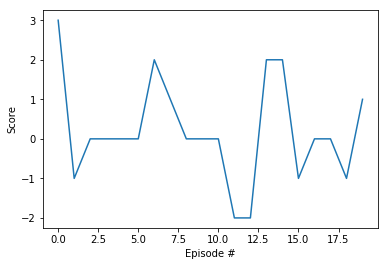

In [10]:
# train for 20 episodes with a maximum of 100 timesteps

agent, scores = train(env, n_episodes=20, max_t=100, save_filename=None)
print(agent.qnetwork_local)
plot_scores(scores)

 35%|███▌      | 529/1500 [07:43<15:52,  1.02it/s, episode=529, score_mean=13]   


Environment solved in 430 episodes!
Average Score: 13.08
QNetwork(
  (fc1): Linear(in_features=37, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


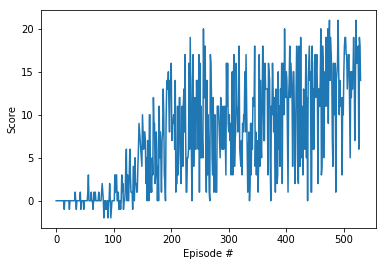

In [11]:
# train for 1500 episddes with a maximum of 1000 timesteps and save the checkpoint
agent, scores = train(env, n_episodes=1500, max_t=1000, save_filename='project1_dqn_agent.pth')
print(agent.qnetwork_local)
plot_scores(scores)

The environment needs to be closed.

In [12]:
env.close()